In [1]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.
"""

import numpy as np
import torch
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
from utils import make_dir, plot_grid_from_points, aggregate_x_y, normal_fine_grid, plot_datapoints, plot_fine_grid, standardize_for_plotting
import matplotlib.pyplot as plt
from mcc import mean_corr_coef as mcc
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/private/home/vitoriabp/.conda/envs/research/lib/python3.11/site-packages/torch/__init__.py:608: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1682925190303/work/torch/csrc/tensor/python_tensor.cpp:439.)
  _C._set_default_tensor_type(t)


# Dataset: Nonfactorized support

In [2]:
import testdistr
import seaborn as sns

In [3]:
dset = testdistr.build_2D_dataset_non_factorized_support(n_samples=50000, data_seed=2, prior_seed=67280421310721)

Text(0.5, 1.0, 'z ')

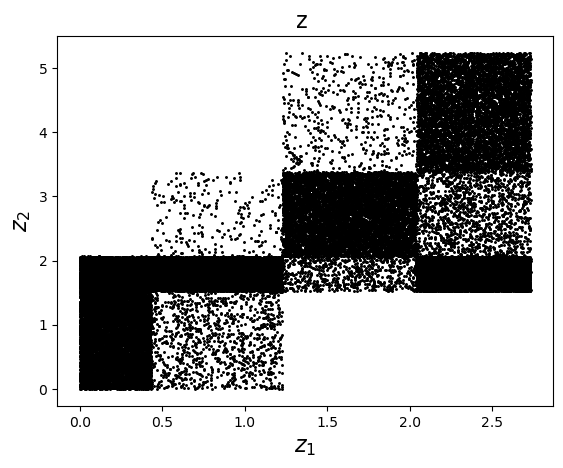

In [4]:
plot_datapoints(dset.z)
plt.xlabel(r"$z_1$", fontsize=16)
plt.ylabel(r"$z_2$", fontsize=16)
plt.title("z ", fontsize=16)

In [5]:
n_samples_grid = 20 # for plotting

In [6]:
separators = dset.separators
d_data, d_latent = dset.get_dims()

ftrue = dset.model
ftrue.to(device)
ftrue.train(mode=False)

sep_x = np.array(separators[0])
sep_y = np.array(separators[1])
n_separators = len(sep_x) + len(sep_y)
agg = aggregate_x_y(sep_x, sep_y, n_interm=n_samples_grid)
agg = torch.Tensor(agg)

grid_x_std, grid_y_std = normal_fine_grid(bound=3.5, data=dset.z,  n_points=n_samples_grid)
agg_grid = np.stack((grid_x_std, grid_y_std), axis=2) # aggregrate grid
agg_grid = torch.Tensor(agg_grid)

Text(0.5, 1.0, '$z_1$')

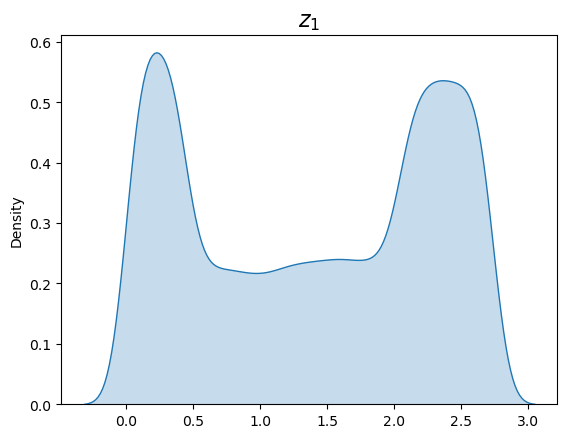

In [7]:
f = plt.figure()
sns.kdeplot(dset.z[:,0].cpu().numpy(), fill=True)
plt.title(r'$z_1$', fontsize=16)

Text(0.5, 1.0, '$z_2$')

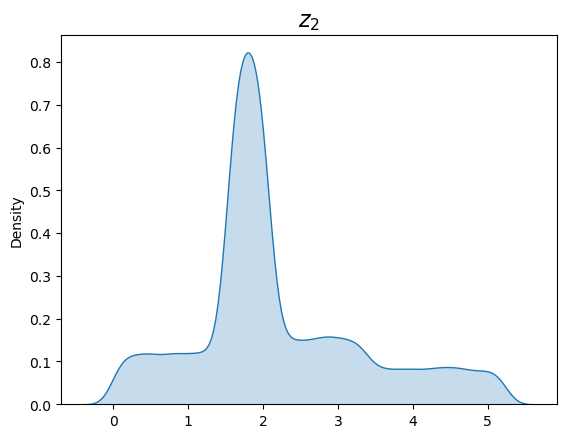

In [8]:
f = plt.figure()
sns.kdeplot(dset.z[:,1].cpu().numpy(), fill=True)
plt.title(r'$z_2$', fontsize=16)

In [9]:
z_true_standardized, true_fine_grid_standardized, true_separators_standardized, mean, std = standardize_for_plotting(dset.z, agg_grid, agg)

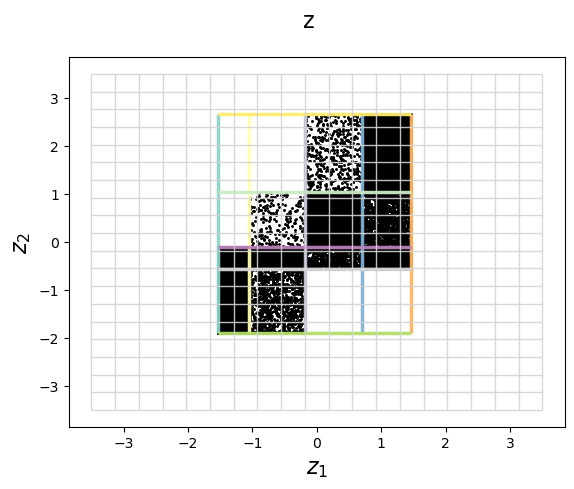

In [10]:
fig2, ax, ar = plot_grid_from_points(true_separators_standardized, alpha=0.95)
_ = plot_fine_grid(true_fine_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(z_true_standardized)
ax.set_xlabel(r'$z_1$', fontsize=16)
ax.set_ylabel(r'$z_2$', fontsize=16)
fig2.suptitle('z', fontsize=16)
plt.show()

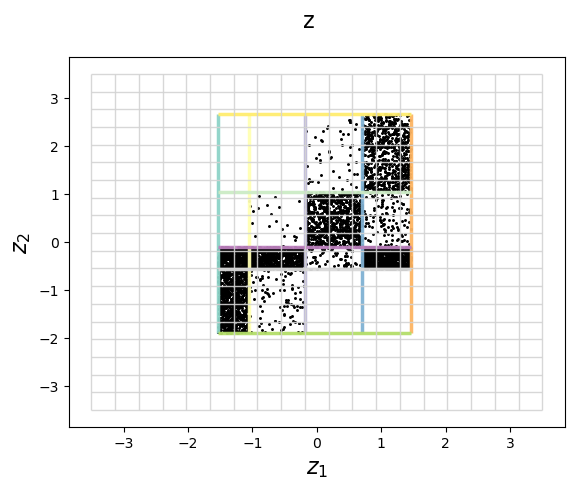

In [11]:
fig2, ax, ar = plot_grid_from_points(true_separators_standardized, alpha=0.95)
_ = plot_fine_grid(true_fine_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(z_true_standardized[0:5000])
ax.set_xlabel(r'$z_1$', fontsize=16)
ax.set_ylabel(r'$z_2$', fontsize=16)
fig2.suptitle('z', fontsize=16)
plt.show()

Correlation between the factors $z_1$ and $z_2$:

In [12]:
print("--- Correlation coefficient ", np.corrcoef(dset.z[:,0].cpu().numpy(), dset.z[:,1].cpu().numpy())[0,1], " ---")

--- Correlation coefficient  0.6062386485133533  ---


## Oberved variables

In [13]:
x = dset.x

agg = torch.Tensor(agg)

nn = dset.model
separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
grid_x = nn(agg_grid.view(-1,2)).reshape(agg_grid.shape)

In [14]:
x_standardized, x_grid_standardized, x_separators_standardized, mean_x, std_x = standardize_for_plotting(x, grid_x, separators_x)

Text(0.5, 0.98, 'x')

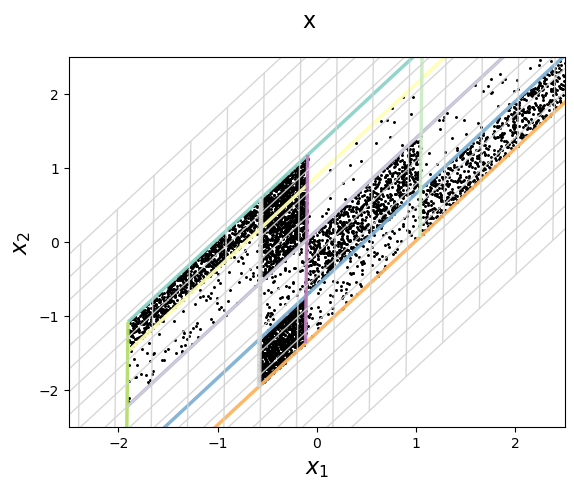

In [16]:
fig2, ax, ar = plot_grid_from_points(x_separators_standardized, alpha=0.95)
_ = plot_fine_grid(x_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(x_standardized[0:5000])
ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
fig2.suptitle('x', fontsize=16)

## Our algorithm

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from parzen import ParzenWindowsGaussian
from criterion import criterion, compute_alpha, compute_density_grad
from models import linear_transf

In [14]:
from utils import to_ndarray

In [15]:
# model initialization seed
seed = 4

In [16]:
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

model=linear_transf()
model.to(device)
model.train(mode=True)

nn = dset.model
nn.to(device)
nn.train(mode=False)

linear_transf(
  (fc3): Linear(in_features=2, out_features=2, bias=False)
)

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [18]:
loader_params = {'num_workers': 6, 'pin_memory': True} if torch.cuda.is_available() else {}
data_loader = DataLoader(dset, batch_size=5000, shuffle=False, drop_last=True, **loader_params)

In [19]:
n_epochs = 50
sigma = 0.1

## plotting
arrow_scale = 500
n_samples_grid = 20 # for plotting

In [20]:
Xs, V, V_norms = compute_density_grad(dset.x, sigma=sigma, standardize=True, use_log_density=True)

alpha = compute_alpha(V_norms, alpha_mode='as_is', gamma=1.0, return_cdf=False)
dset.alpha = alpha

In [22]:
for epoch in range(1,n_epochs+1):  # loop over the dataset multiple times

    train_loss = 0.0

    for i, data in enumerate(data_loader):
        model.train(mode=True)
        x, z_true, alpha_batch = data
        x = x.to(device)
        alpha_batch = alpha_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        z_prime_orig = model(x)

        if i==0:
            if epoch==1:

                with torch.no_grad():
                    ## preprocess separators
                    sep_x = np.array(separators[0])
                    sep_y = np.array(separators[1])

                    agg = aggregate_x_y(sep_x, sep_y, n_interm=n_samples_grid)

                    ## create fine grid
                    grid_x_std, grid_y_std = normal_fine_grid(bound=2.2, data=dset.z,  n_points=n_samples_grid)
                    agg_grid = np.stack((grid_x_std, grid_y_std), axis=2) # aggregrate grid
                    agg_grid = torch.Tensor(agg_grid)
                    
                    z_true_standardized, true_fine_grid_standardized, true_separators_standardized, mean, std = standardize_for_plotting(z_true, agg_grid, agg)

                    estimator = ParzenWindowsGaussian(sigma) 
                    estimator.train(z_true_standardized)
                    log_grad = estimator.dlogp_dx(z_true_standardized)
                    loggrad = np.reshape(to_ndarray(log_grad), (z_true_standardized.shape[0], log_grad.shape[-1]))
                    dx = loggrad[:,0]
                    dy = loggrad[:,1]
                    magnitude = np.sqrt(dx**2+dy**2)

                    agg = torch.Tensor(agg)

                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    grid_x = nn(agg_grid.view(-1,2)).reshape(agg_grid.shape)

                    x_standardized, x_grid_standardized, x_separators_standardized, mean_x, std_x = standardize_for_plotting(x, grid_x, separators_x)      

            model.eval()
            with torch.no_grad():
                mcc_score = mcc(z_prime_orig.detach().cpu().numpy(), z_true.detach().cpu().numpy())
                print("MCC: ", mcc_score)


                separators_zprime = model(nn(agg.view(-1,2))).reshape(agg.shape)
                grid_zprime = model(nn(agg_grid.view(-1,2))).reshape(agg_grid.shape)


                z_prime_standardized, fine_grid_standardized, separators_standardized, mean, std = standardize_for_plotting(z_prime_orig, grid_zprime, separators_zprime)

        loss, loss_terms_dict, gradient_norms = criterion(X=z_prime_orig,
                                                                obs=x,
                                                                lambda_gr_local_align=-1,
                                                                lambda_gr_axis_align=1.0,
                                                                lambda_pts_axis_align=-1,
                                                                lambda_pts_gr_ortho=-1, 
                                                                lambda_rec=-1,
                                                                lambda_marginal=-1,
                                                                sigma_parzen=sigma, multiplicity=1, use_abs_cosine=False, 
                                                                gamma=1.0, require_neighbor_also_has_large_gradient=True,
                                                                use_log_density_gradient=True,
                                                                sampling_bandwidth=0.0,
                                                                alpha_mode="as_is",
                                                                compute_cdf=False,
                                                                sigma_neighbors=sigma,
                                                                standardize_batch=True,
                                                                gamma_robust=None,
                                                                alpha=alpha_batch)

        loss.backward(retain_graph=False)


        optimizer.step()

        train_loss += loss.item()

        

    train_loss /= len(data_loader)

    print('epoch', epoch,  '-- train_loss', train_loss)

MCC:  0.5472206250829794
epoch 1 -- train_loss -0.08924525591384716
MCC:  0.9813218419300165
epoch 2 -- train_loss -0.09324011149078679
MCC:  0.9988158218931655
epoch 3 -- train_loss -0.0936488231510125
MCC:  0.9991611141807912
epoch 4 -- train_loss -0.09373048110346635
MCC:  0.9999013235795544
epoch 5 -- train_loss -0.09373960596141793
MCC:  0.9995173202196783
epoch 6 -- train_loss -0.09376922352436315
MCC:  0.9998789080669884
epoch 7 -- train_loss -0.0937545482514236
MCC:  0.999722910045773
epoch 8 -- train_loss -0.09376144985522612
MCC:  0.9998815884649759
epoch 9 -- train_loss -0.09375978660287768
MCC:  0.999748873131562
epoch 10 -- train_loss -0.09376233264669545
MCC:  0.9997486537754052
epoch 11 -- train_loss -0.09374556781728313
MCC:  0.9996496020977742
epoch 12 -- train_loss -0.09376047923959192
MCC:  0.9998630465567603
epoch 13 -- train_loss -0.09373048495124178
MCC:  0.9991605150265851
epoch 14 -- train_loss -0.09375882264482477
MCC:  0.9999398747251037
epoch 15 -- train_loss

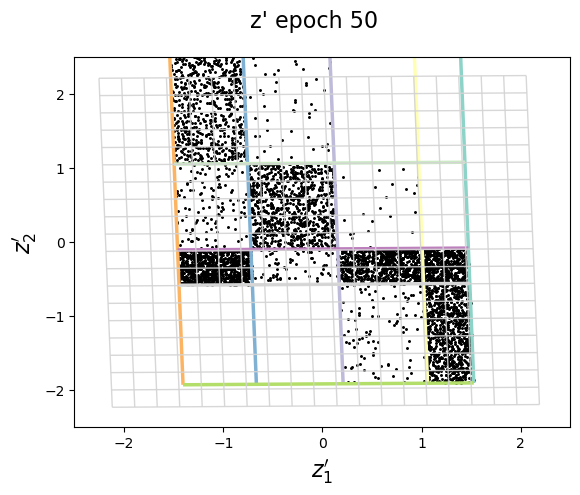

In [23]:
fig2, ax2, _ = plot_grid_from_points(separators_standardized, array=ar)
_ = plot_fine_grid(fine_grid_standardized, alpha=0.9, ax=ax2)
plot_datapoints(z_prime_standardized)
ax2.set_xlabel(r"$z_1'$", fontsize=16)
ax2.set_ylabel(r"$z_2'$", fontsize=16)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
fig2.suptitle("z\' epoch "+str(epoch), fontsize=16)
plt.show()

## ICA results

In [25]:
from sklearn.decomposition import FastICA

In [38]:
# model initialization seed
seed = 3

In [39]:
X = dset.x.cpu().detach().numpy()
transformer = FastICA(n_components=2, random_state=seed, whiten='unit-variance', max_iter=1000)
S_est = transformer.fit_transform(X)

In [40]:
mcc_score = mcc(S_est, dset.z.detach().cpu().numpy())
print("MCC: ", mcc_score)

MCC:  0.8611569919021819


In [41]:
# this matrix is already including the whitening!
unmixing_matrix_white = transformer.components_
unmixing_matrix_white = torch.Tensor(unmixing_matrix_white)

mixing = transformer.mixing_
mixing = torch.Tensor(mixing)

shift = transformer.mean_
shift = torch.Tensor(shift)

X = torch.tensor(X)
Z_ica = torch.matmul(X, unmixing_matrix_white)

In [42]:
xsep = ftrue(agg.view(-1,2).to(device)) - shift
xgrid = ftrue(agg_grid.view(-1,2).to(device)) - shift

separators_zprime = torch.matmul(unmixing_matrix_white, xsep.T ).T.reshape(true_separators_standardized.shape)
grid_zprime = torch.matmul(unmixing_matrix_white, xgrid.T ).T.reshape(true_fine_grid_standardized.shape)

In [43]:
# reduce the number of data samples for cleaner plot
S_est = S_est[0:5000]

z_prime_standardized, fine_grid_standardized, separators_standardized, mean, std = standardize_for_plotting(S_est, grid_zprime, separators_zprime)

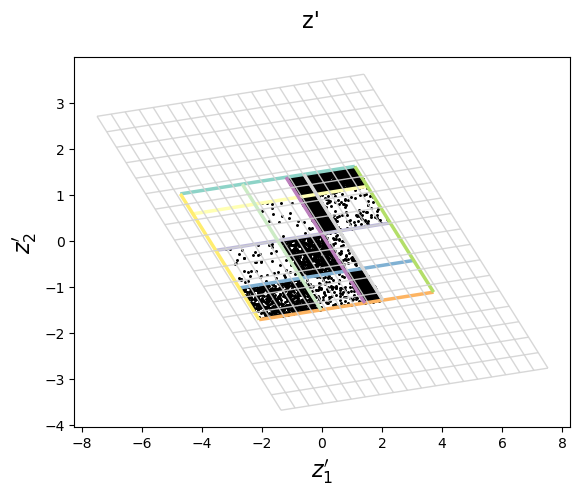

In [44]:
fig2, ax2, _ = plot_grid_from_points(separators_standardized, array=ar)
_ = plot_fine_grid(fine_grid_standardized, alpha=0.9, ax=ax2)
plot_datapoints(z_prime_standardized)
ax2.set_xlabel(r"$z_1'$", fontsize=16)
ax2.set_ylabel(r"$z_2'$", fontsize=16)
fig2.suptitle("z\' ", fontsize=16)
plt.show()

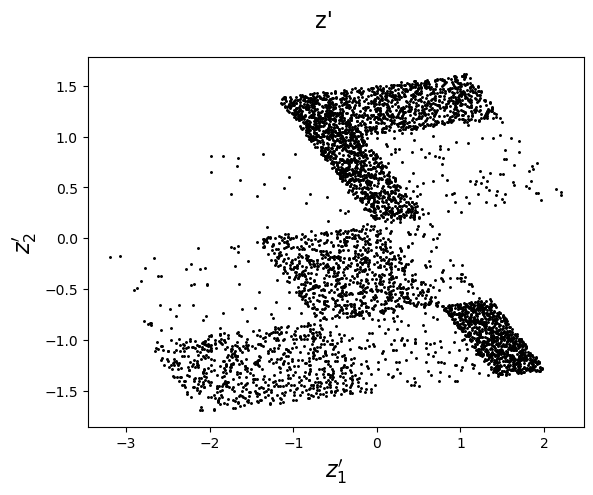

In [45]:
f, ax = plt.subplots()
plot_datapoints(z_prime_standardized)
ax.set_xlabel(r"$z_1'$", fontsize=16)
ax.set_ylabel(r"$z_2'$", fontsize=16)
f.suptitle("z\' ", fontsize=16)
plt.show()

## Hausdorff Factorized Support results

In [21]:
from factorized_support import Loss

In [43]:
# model initialization seed
seed=3 

np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

model=linear_transf()
model.to(device)
model.train(mode=True)

nn = dset.model
nn.to(device)
nn.train(mode=False)

optimizer = optim.SGD(model.parameters(), lr=0.0001)

n_epochs = 100

In [44]:
for epoch in range(1,n_epochs+1):  # loop over the dataset multiple times

    for i, data in enumerate(data_loader):
        model.train(mode=True)
        x, z_true, alpha_batch = data
        x = x.to(device)
        alpha_batch = alpha_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        z_prime_orig = model(x)

        if i==0:
            if epoch==1:

                with torch.no_grad():
                    ## preprocess separators
                    sep_x = np.array(separators[0])
                    sep_y = np.array(separators[1])

                    agg = aggregate_x_y(sep_x, sep_y, n_interm=n_samples_grid)

                    ## create fine grid
                    grid_x_std, grid_y_std = normal_fine_grid(bound=2.2, data=dset.z,  n_points=n_samples_grid)
                    agg_grid = np.stack((grid_x_std, grid_y_std), axis=2) # aggregrate grid
                    agg_grid = torch.Tensor(agg_grid)
                    
                    z_true_standardized, true_fine_grid_standardized, true_separators_standardized, mean, std = standardize_for_plotting(z_true, agg_grid, agg)

                    estimator = ParzenWindowsGaussian(sigma) 
                    estimator.train(z_true_standardized)
                    log_grad = estimator.dlogp_dx(z_true_standardized)
                    loggrad = np.reshape(to_ndarray(log_grad), (z_true_standardized.shape[0], log_grad.shape[-1]))
                    dx = loggrad[:,0]
                    dy = loggrad[:,1]
                    magnitude = np.sqrt(dx**2+dy**2)

                    agg = torch.Tensor(agg)

                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    grid_x = nn(agg_grid.view(-1,2)).reshape(agg_grid.shape)

                    x_standardized, x_grid_standardized, x_separators_standardized, mean_x, std_x = standardize_for_plotting(x, grid_x, separators_x)      

            model.eval()
            with torch.no_grad():
                mcc_score = mcc(z_prime_orig.detach().cpu().numpy(), z_true.detach().cpu().numpy())
                print("MCC: ", mcc_score)

                separators_zprime = model(nn(agg.view(-1,2))).reshape(agg.shape)
                grid_zprime = model(nn(agg_grid.view(-1,2))).reshape(agg_grid.shape)

                z_prime_standardized, fine_grid_standardized, separators_standardized, mean, std = standardize_for_plotting(z_prime_orig, grid_zprime, separators_zprime)


            loss_def = Loss(n_data=2, matching='hausdorff_hard')
            loss = loss_def(data=x, z=z_prime_orig)
            train_loss = loss['loss']
            train_loss.backward(retain_graph=True)
            optimizer.step()

    print('epoch', epoch,  '-- train_loss', train_loss)

MCC:  0.847831585055436
epoch 1 -- train_loss tensor(4982.5675, grad_fn=<AddBackward0>)
MCC:  0.9948720847867434
epoch 2 -- train_loss tensor(4952.7430, grad_fn=<AddBackward0>)
MCC:  0.9880589008665916
epoch 3 -- train_loss tensor(4919.3054, grad_fn=<AddBackward0>)
MCC:  0.9821056806152806
epoch 4 -- train_loss tensor(4885.9178, grad_fn=<AddBackward0>)
MCC:  0.9784639539083906
epoch 5 -- train_loss tensor(4852.5047, grad_fn=<AddBackward0>)
MCC:  0.976025552865097
epoch 6 -- train_loss tensor(4819.0767, grad_fn=<AddBackward0>)
MCC:  0.9742786329773938
epoch 7 -- train_loss tensor(4785.6429, grad_fn=<AddBackward0>)
MCC:  0.9729592884726483
epoch 8 -- train_loss tensor(4752.2064, grad_fn=<AddBackward0>)
MCC:  0.971922092682399
epoch 9 -- train_loss tensor(4718.7691, grad_fn=<AddBackward0>)
MCC:  0.9710793139768072
epoch 10 -- train_loss tensor(4685.3310, grad_fn=<AddBackward0>)
MCC:  0.9703734913964653
epoch 11 -- train_loss tensor(4651.8920, grad_fn=<AddBackward0>)
MCC:  0.96976698627529

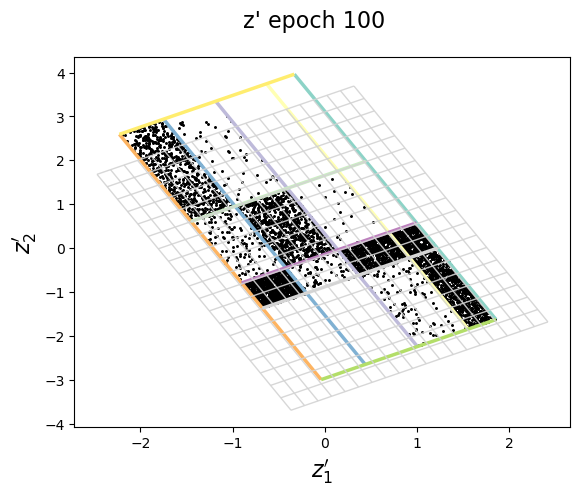

In [45]:
fig2, ax2, _ = plot_grid_from_points(separators_standardized, array=ar)
_ = plot_fine_grid(fine_grid_standardized, alpha=0.9, ax=ax2)
plot_datapoints(z_prime_standardized)
ax2.set_xlabel(r"$z_1'$", fontsize=16)
ax2.set_ylabel(r"$z_2'$", fontsize=16)
# plt.xlim(-2.5,2.5)
# plt.ylim(-2.5,2.5)
fig2.suptitle("z\' epoch "+str(epoch), fontsize=16)
plt.show()